# Data-Augmentation

---

## Overview
本ノートブックでは[albumentaitons](https://github.com/albumentations-team/albumentations)を使用してデータ拡張を行うとともに、後続のモデル学習の前準備としてデータの分割を行います。

## Usage

### 1. データ拡張

albumentationsにおいては、BBoxの座標変換後の値が正規化された[0,1]の範囲を超えてしまうバグが報告されています。<br>
[参考](https://github.com/albumentations-team/albumentations/issues/459)<br>
これを参考に、本プログラムではそのエラーの回避策として、以下の流れでBBoxの座標変換を行っています。<br>


1.   入力のYOLO形式のBBoxをPascal VOC形式に変換します。

2.   Alumentationsによるデータ拡張を行います。
2.   データ拡張後のBBoxを、再びYOLO形式に変換します。



In [2]:
import os
from typing import List, Tuple
import cv2
from tqdm import tqdm
import albumentations as A


class ImageAugmentor:
    """画像とラベルを拡張するためのクラス
    """
    def __init__(self, input_images, input_labels, save_directory):
        """コンストラクタ

        Args:
            input_images (str): 入力画像が保存されているディレクトリへのパス
            input_labels (str): 入力ラベルが保存されているディレクトリへのパス
            save_directory (str): 拡張された画像とラベルを保存するディレクトリへのパス
        """
        self.input_images = input_images
        self.input_labels = input_labels
        self.save_directory = save_directory

        self.create_save_directory()

    def create_save_directory(self):
        """出力先のディレクトリを生成する
        """
        if not os.path.exists(os.path.join(self.save_directory, "images")):
            os.makedirs(os.path.join(self.save_directory, "images"))
        if not os.path.exists(os.path.join(self.save_directory, "labels")):
            os.makedirs(os.path.join(self.save_directory, "labels"))

    def count_files_in_directory(self, directory_path):
        """指定されたディレクトリ内のファイル数をカウントする

        Args:
            directory_path (str): ファイル数をカウントするディレクトリのパス

        Returns:
            int: ディレクトリ内のファイル数
        """
        return sum([len(files) for _, _, files in os.walk(directory_path)])

    def print_file_counts(self):
        """データ拡張後のファイル数を表示する
        """
        num_images = self.count_files_in_directory(os.path.join(self.save_directory, "images"))
        num_labels = self.count_files_in_directory(os.path.join(self.save_directory, "labels"))

        print(f"Generated {num_images} images and {num_labels} labels.")

    def yolo_to_pascal_voc_bbox(self, bbox, img_width, img_height):
        """YOLO形式のBBoxをPascal VOC形式に変換する

        Args:
            bbox (Tuple[float, float, float, float]): YOLO形式のBBox (x_center, y_center, width, height)
            img_width (int): 画像の幅
            img_height (int): 画像の高さ

        Return:
            Tuple[float, float, float, float]: Pascal VOC形式のBBox (x_min, y_min, x_max, y_max)
        """
        x_center, y_center, width, height = bbox
        x_min = img_width * (x_center - width / 2)
        y_min = img_height * (y_center - height / 2)
        x_max = x_min + img_width * width
        y_max = y_min + img_height * height
        return x_min, y_min, x_max, y_max

    def pascal_voc_bbox_to_yolo(self, bbox, img_width, img_height):
        """Pascal VOC形式のBBoxをYOLO形式に変換する

        Args:
             bbox (Tuple[float, float, float, float]): Pascal VOC形式のBBox (x_min, y_min, x_max, y_max)
            img_width (int): 画像の幅
            img_height (int): 画像の高さ

        Returns:
            Tuple[float, float, float, float]: YOLO形式のBBox (x_center, y_center, width, height)
        """
        x_min, y_min, x_max, y_max = bbox
        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        return x_center, y_center, width, height

    def compose_augmentation(self):
        """Albumentationsを使用してデータ拡張のパイプラインを構成する

        Returns:
            A.Compose: 一連のデータ拡張を組み合わせたAlbumentationsのComposeオブジェクト
        """
        transform = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            # TODO: 必要に応じてさらにデータ拡張を追加する
        ]
        return A.Compose(transform, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    def is_valid_bbox(self, x_center, y_center, width, height, img_shape, threshold=0.05):
        """与えられたYOLO形式のBBoxが画像の境界内にあるかどうかを判定する

        Args:
            x_center (float): BBoxの中心のx座標
            y_center (float): BBoxの中心のy座標
            width (float): BBoxの幅
            height (float): BBoxの高さ
            img_shape (tuple): 画像の形状（幅, 高さ）
            threshold (Optional[float]): 境界の許容範囲を決める閾値（デフォルトは0.05）

        Returns:
            bool: BBoxが画像の境界内にある場合はTrue、そうでない場合はFalse
        """
        min_x = x_center - width / 2
        min_y = y_center - height / 2
        max_x = x_center + width / 2
        max_y = y_center + height / 2

        if (
            min_x < threshold or
            min_y < threshold or
            max_x > img_shape[1] - threshold or
            max_y > img_shape[0] - threshold
        ):
            return False
        return True

    def save_augmented_images_and_labels(self, augmentations, image, bboxes, labels, augmented_img_file, augmented_label_file):
        """与えられた画像と対応するBBoxにデータ拡張を適用し、結果として得られる拡張された画像とラベルを指定のファイルパスに保存する

        Args:
            augmentations (A.Compose): データ拡張を適用するためのAlbumentationsのComposeオブジェクト
            image (ndarray): データ拡張を適用する画像
            bboxes (List[Tuple[float, float, float, float]]): 画像に対応するBBoxのリスト
            labels (list[int]): BBoxに対応するクラスラベルのリスト
            augmented_img_file (str): 拡張された画像を保存するためのファイルパス
            augmented_label_file (str): 拡張されたラベルを保存するためのファイルパス

        Raises:
            Exception: 画像やラベルの保存中にエラーが発生した場合に発生させる例外
        """
        try:
            augmented = augmentations(image=image, bboxes=bboxes, class_labels=labels)
            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']

            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_img_file, aug_img)

            with open(augmented_label_file, "w") as f:
                for aug_bbox, label in zip(aug_bboxes, augmented['class_labels']):
                    yolo_bbox = self.pascal_voc_bbox_to_yolo(aug_bbox, aug_img.shape[1], aug_img.shape[0])
                    f.write(f"{label} {' '.join(map(str, yolo_bbox))}\n")
        except Exception as e:
              print(f"Error occurred while saving augmented image to {augmented_img_file} and label to {augmented_label_file}")
              print(f"Error details: {e}")

    def run_augmentations(self, augmentations, num_augmentations):
        """与えられた画像とラベルのペアに対してデータ拡張を行い、その結果を保存する

        Args:
            augmentations (A.Compose): Albumentationsで定義されたデータ拡張のパイプライン
            num_augmentations (int): 各画像に対して行うデータ拡張の回数

        Raises:
            Exception: 画像またはラベルファイルの処理中に何らかのエラーが発生した場合

        Note:
            - GrondingDINOによる自動アノテーションの都合上、オブジェクトが検出できない場合は、ラベルファイルが空になる
            　上記ケースを考慮して、ラベルファイルが空の場合はデータ拡張を行わないようにしている
            - BBoxが画像の範囲外である場合、その画像はデータ拡張の対象外となる
        """
        img_files = [os.path.join(self.input_images, fname) for fname in os.listdir(self.input_images) if fname.endswith(".jpg")]
        label_files = [os.path.join(self.input_labels, fname.replace(".jpg", ".txt")) for fname in os.listdir(self.input_images) if fname.endswith(".jpg")]

        for img_file, label_file in tqdm(zip(img_files, label_files), total=len(img_files)):
          try:
              image = cv2.imread(img_file)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

              with open(label_file, "r") as f:
                  lines = f.readlines()

              if not lines:
                  continue

              bboxes = []
              labels = []

              skip_augmentation = False
              for line in lines:
                  data = line.strip().split()
                  label = int(data[0])
                  bbox_data = tuple(map(float, data[1:]))
                  x_center, y_center, width, height = bbox_data
                  if not self.is_valid_bbox(x_center * image.shape[1], y_center * image.shape[0], width * image.shape[1], height * image.shape[0], image.shape):
                      skip_augmentation = True
                      break
                  bboxes.append(self.yolo_to_pascal_voc_bbox(bbox_data, image.shape[1], image.shape[0]))
                  labels.append(label)

              if skip_augmentation:
                  continue

              img_filename = os.path.basename(img_file)
              label_filename = os.path.basename(label_file)

              for i in range(num_augmentations):
                  img_save_path = os.path.join(self.save_directory, "images", f"{i}_{img_filename}")
                  label_save_path = os.path.join(self.save_directory, "labels", f"{i}_{label_filename}")
                  self.save_augmented_images_and_labels(augmentations, image, bboxes, labels, img_save_path, label_save_path)
          except Exception as e:
              print(f"Error occurred while processing image file: {img_file} and label file: {label_file}")
              print(f"Error details: {e}")

        self.print_file_counts()

In [6]:
# ------------------------------
# 実行前のパラメータ設定
# ------------------------------
input_images = "../../auto_annotation/annotation_results3/original_images"
input_labels = "../../auto_annotation/annotation_results3/labels"
save_directory = "../aug_images2"
num_augmentations = 5

In [8]:
image_augmentor = ImageAugmentor(input_images, input_labels, save_directory)
augmentations = image_augmentor.compose_augmentation()
image_augmentor.run_augmentations(augmentations, num_augmentations)

100% 100/100 [00:02<00:00, 43.60it/s]

Generated 415 images and 415 labels.


## Visualization

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bboxes_on_image(image, label_content):
    """与えられた画像にYOLO形式のラベルをもとにBBoxを描画する

    Args:
        image (np.ndarray): BBoxを描画する対象の画像。
        label_content (List[str]): YOLO形式のBBox情報を含む文字列のリスト

    Returns:
        np.ndarray: BBoxが描画された画像
    """
    for line in label_content:
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)
        x_center, y_center, width, height = int(x_center * image.shape[1]), int(y_center * image.shape[0]), int(width * image.shape[1]), int(height * image.shape[0])
        top_left = (x_center - width // 2, y_center - height // 2)
        bottom_right = (x_center + width // 2, y_center + height // 2)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    return image

def draw_bbox_grid(input_images, input_labels, grid_shape=(5, 5)):
    """与えられたディレクトリから画像とラベルを読み込み、複数の画像をグリッド上に並べ、それぞれの画像内の対象物にBBoxを描画する

    Args:
        input_images (str): 画像が保存されているディレクトリへのパス
        input_labels (str): ラベルが保存されているディレクトリへのパス
        grid_shape (Optional[Tuple[int, int]]): グリッドの形状を示す行と列のペア

    Note:
        - グリッドに描画される画像は、ディレクトリ内の画像ファイルの順序に基づいている
        - 画像が不足している場合、グリッドの一部が空になる可能性がある
    """
    img_files = sorted([os.path.join(input_images, fname) for fname in os.listdir(input_images) if fname.endswith(".jpg")])
    label_files = sorted([os.path.join(input_labels, fname) for fname in os.listdir(input_labels) if fname.endswith(".txt")])

    if len(img_files) == 0 or len(label_files) == 0:
        print("No images or labels found.")
        return

    max_height_per_row = []
    total_width = []

    for row in range(grid_shape[0]):
        row_images = []
        row_height = 0
        row_width = 0
        for col in range(grid_shape[1]):
            index = row * grid_shape[1] + col
            if index >= len(img_files):
                break
            image = cv2.imread(img_files[index])
            with open(label_files[index], 'r') as f:
                label_content = f.readlines()
            image = draw_bboxes_on_image(image, label_content)
            row_images.append(image)
            row_height = max(row_height, image.shape[0])
            row_width += image.shape[1]

        max_height_per_row.append(row_height)
        total_width.append(row_width)

    grid_image = np.zeros((sum(max_height_per_row), max(total_width), 3), dtype=np.uint8)

    y_offset = 0
    for row in range(grid_shape[0]):
        x_offset = 0
        for col in range(grid_shape[1]):
            index = row * grid_shape[1] + col
            if index >= len(img_files):
                break
            image = cv2.imread(img_files[index])
            with open(label_files[index], 'r') as f:
                label_content = f.readlines()
            image = draw_bboxes_on_image(image, label_content)
            grid_image[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image
            x_offset += image.shape[1]
        y_offset += max_height_per_row[row]

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # 軸を非表示にする
    plt.show()

### 元画像

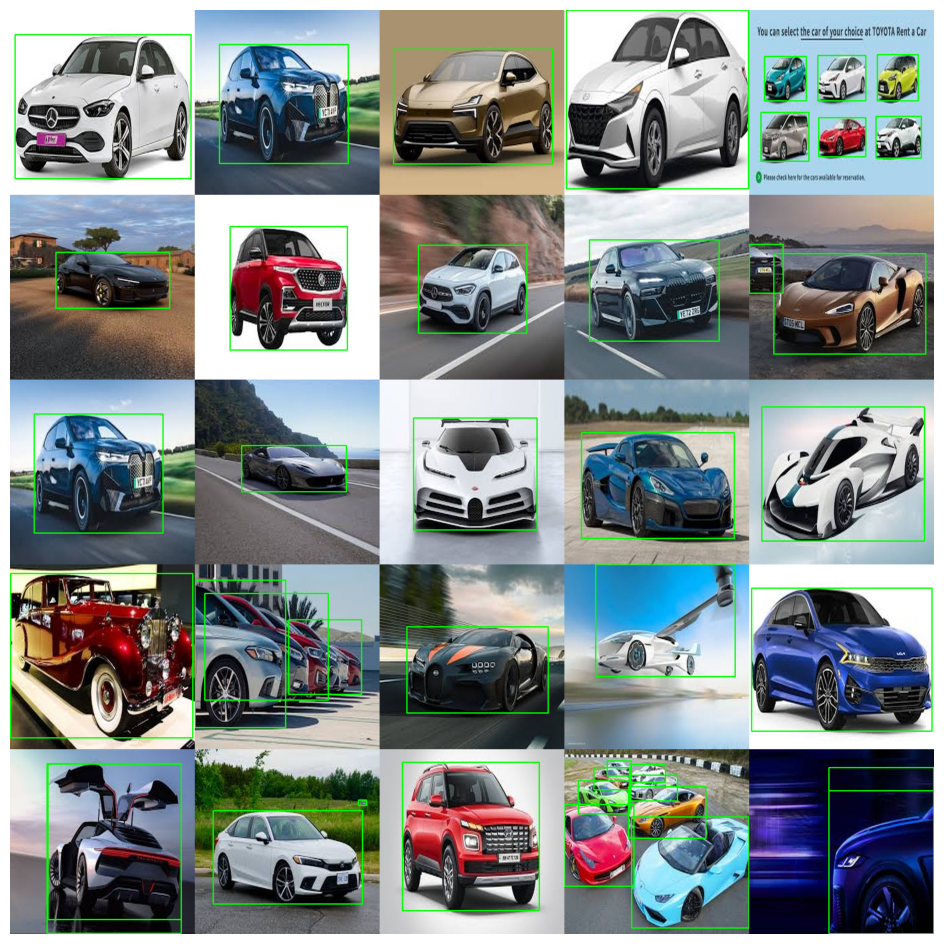

In [7]:
draw_bbox_grid(input_images, input_labels)

### データ拡張後の画像
以下のような結果になりました。<br>
データ拡張に対応してBBoxが追従できていることが確認できました。<br>

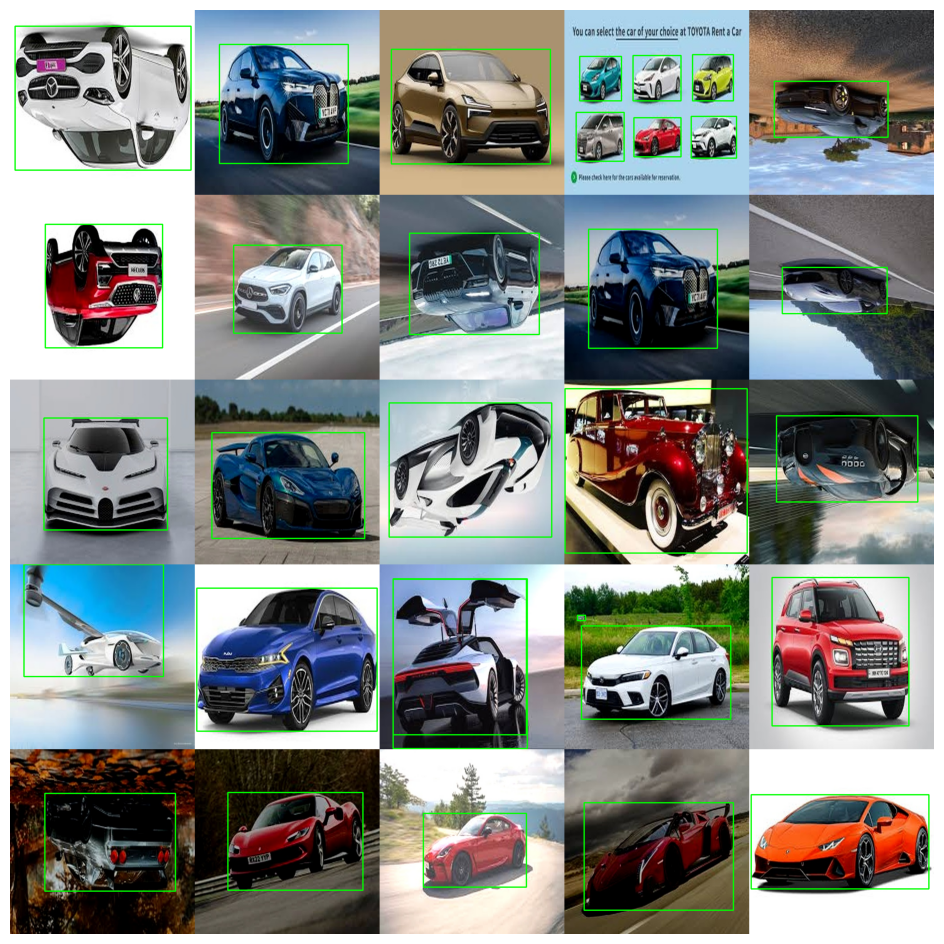

In [9]:
augmented_input_images = '../aug_images2/images'
augmented_input_labels = '../aug_images2/labels'
draw_bbox_grid(augmented_input_images, augmented_input_labels)

## Usage

###2. データ分割
データ拡張後のデータに対し、後続のモデル学習のため7:2:1の比率でtrain:valid:testにデータを分割します。<br>

In [10]:
import os
import shutil
import random

class DataSplitter:
    """データの分割を行うクラス

    指定された比率に従って、データをtrain, valid, testセットに分割する

    """
    def __init__(self, input_path, output_base_path, output_directory_name, ratio):
        """コンストラクタ

        Args:
            input_path (str): 分割前の画像とラベルが保存されているディレクトリへのパス
            output_base_path (str): 分割後のデータを保存するベースとなるディレクトリへのパス
            output_directory_name (str): 分割後のデータを保存するためのサブディレクトリの名前
            ratio (Tuple[float, float, float]): train, valid, testの分割比率を示す3つの要素からなるタプル(合計は1.0になるようにする必要がある)
        """
        self.input_path = input_path
        self.output_path = os.path.join(output_base_path, output_directory_name)
        self.ratio = ratio

    def count_files_in_directory(self, directory_path):
        """指定されたディレクトリ内のファイル数をカウントする

        Args:
            directory_path (str): ファイル数をカウントするディレクトリのパス

        Returns:
            int: ディレクトリ内のファイル数
        """
        return sum([len(files) for _, _, files in os.walk(directory_path)])

    def print_train_valid_test_counts(self):
        """'train', 'valid', 'test'の各ディレクトリ内に存在する画像とラベルの数を表示する
        """
        for split_folder in ['train', 'valid', 'test']:
            num_images = self.count_files_in_directory(os.path.join(self.output_path, split_folder, "images"))
            num_labels = self.count_files_in_directory(os.path.join(self.output_path, split_folder, "labels"))
            print(f"{split_folder.upper()} - Generated {num_images} images and {num_labels} labels.")

    def run_split_data(self):
        """データ分割を実行する

        指定された比率で画像とラベルを'train', 'valid', 'test'に分割し、
        各ディレクトリにデータをコピー後、ファイル数を表示する

        """
        dirs = ['images', 'labels']
        split_folders = ['train', 'valid', 'test']
        image_exts = ['.jpg', '.jpeg', '.png']

        image_files = [f for f in os.listdir(os.path.join(self.input_path, 'images')) if os.path.splitext(f)[1] in image_exts]
        random.shuffle(image_files)

        train_count = int(len(image_files) * self.ratio[0])
        valid_count = int(len(image_files) * self.ratio[1])

        train_files = image_files[:train_count]
        valid_files = image_files[train_count:train_count+valid_count]
        test_files = image_files[train_count+valid_count:]

        for folder in split_folders:
            for dir_name in dirs:
                new_dir = os.path.join(self.output_path, folder, dir_name)
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir)

        for split_folder, split_files in zip(split_folders, [train_files, valid_files, test_files]):
            for file in split_files:
                src_image = os.path.join(self.input_path, 'images', file)
                dest_image = os.path.join(self.output_path, split_folder, 'images', file)
                shutil.copy(src_image, dest_image)

                label_file = file.rsplit('.', 1)[0] + '.txt'
                src_label = os.path.join(self.input_path, 'labels', label_file)
                dest_label = os.path.join(self.output_path, split_folder, 'labels', label_file)
                shutil.copy(src_label, dest_label)

        self.print_train_valid_test_counts()

In [12]:
# ------------------------------
# 実行前のパラメータ設定
# ------------------------------
input_path = "../aug_images2"
output_base_path = "../../object_detection/yolov8/dataset"
output_directory_name = "car"
ratio = (0.7, 0.2, 0.1)

In [13]:
data_splitter = DataSplitter(input_path, output_base_path, output_directory_name, ratio)
data_splitter.run_split_data()

TRAIN - Generated 290 images and 290 labels.
VALID - Generated 83 images and 83 labels.
TEST - Generated 42 images and 42 labels.
